In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, '../tools/')

from tools import * 

In [2]:
config = pd.Series({
    'path': os.path.abspath('../dades'),
    'file_type':'csv',
    'years':[2019],
    'dataset': 'BicingNou_ESTACIONS_CLEAN'
})


In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:37479 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.44 GB


# Read data

In [4]:
%%time

data = read_dask_dataframes(config.path, config.file_type, config.dataset, config.years)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 365 ms, sys: 49.7 ms, total: 415 ms
Wall time: 397 ms


# 2019 

In [5]:
config_year = pd.Series({
    'path':config.path,
    'file_type':config.file_type,
    'year':2019,
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [6]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [7]:
first_size = get_ddf_shape(data[config_year.year])

In [8]:
data[config_year.year]

,station_id,physical_configuration,lat,lon,street_name,num_docks_available,num_bikes_available,status,last_updated,is_installed,is_renting,is_returning,is_charging_station,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,post_code,year_last_updated_date,month_last_updated_date,dayofweek_last_updated_date,dayofmonth_last_updated_date,dayofyear_last_updated_date,hour_last_updated_date,street_number,capacity,altitude,last_reported
npartitions=12,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Preprocessing

In [9]:
%%time

# do not execute everytime, takes 17s and eat the memory. Once executed disable the cell and restart the notebook. Since this cell saves a checkpoint you can continue without it.

data[config_year.year] = data[config_year.year].drop(['physical_configuration','lat','lon','post_code', 'last_reported', 'street_number', 'street_name', 'altitude', 'capacity'], axis=1)

data[config_year.year]['station_id']=data[config_year.year]['station_id'].astype(int)
data[config_year.year]['is_charging_station']=data[config_year.year]['is_charging_station'].astype(int)
data[config_year.year]['last_updated']=data[config_year.year]['last_updated'].astype(int)
data[config_year.year]['year_last_updated_date']=data[config_year.year]['year_last_updated_date'].astype(int)
data[config_year.year]['month_last_updated_date']=data[config_year.year]['month_last_updated_date'].astype(int)
data[config_year.year]['dayofweek_last_updated_date']=data[config_year.year]['dayofweek_last_updated_date'].astype(int)
data[config_year.year]['dayofmonth_last_updated_date']=data[config_year.year]['dayofmonth_last_updated_date'].astype(int)
data[config_year.year]['dayofyear_last_updated_date']=data[config_year.year]['dayofyear_last_updated_date'].astype(int)
data[config_year.year]['hour_last_updated_date']=data[config_year.year]['hour_last_updated_date'].astype(int)

data[config_year.year]['status']=data[config_year.year]['status'].round().astype(int)
data[config_year.year]['is_installed']=data[config_year.year]['is_installed'].round().astype(int)
data[config_year.year]['is_renting']=data[config_year.year]['is_renting'].round().astype(int)
data[config_year.year]['is_returning']=data[config_year.year]['is_returning'].round().astype(int)

# Found two station with alot of missing values 
# best solution is to remove
# condition = (data[config_year.year]['station_id'].isin([520.0, 527.0, 532.0]))
# data[config_year.year] = data[config_year.year].mask(condition, np.nan)
# data[config_year.year] = data[config_year.year].dropna(subset=['station_id'])

last_size = get_ddf_shape(data[config_year.year])

new_columns = {
    'last_updated': 'timestamp',
    'year_last_updated_date':'year', 
    'month_last_updated_date':'month',
    'dayofweek_last_updated_date':'dayofweek', 
    'dayofmonth_last_updated_date':'day', 
    'dayofyear_last_updated_date':'dayofyear',
    'hour_last_updated_date':'hour'
}

data[config_year.year] = data[config_year.year].rename(columns=new_columns)

CPU times: user 1.24 s, sys: 12.4 ms, total: 1.25 s
Wall time: 3.02 s


In [10]:
save_checkpoint(data[config_year.year], config_year)

# checkpoint saved.
# CPU times: user 2.12 s, sys: 250 ms, total: 2.37 s
# Wall time: 17.3 s

checkpoint saved.


In [11]:
%%time

data[config_year.year] = load_checkpoint(config_year)

# checkpoint reloaded.

checkpoint reloaded.
CPU times: user 16.9 ms, sys: 0 ns, total: 16.9 ms
Wall time: 15.8 ms


In [12]:
%%time

last_size = get_ddf_shape(data[config_year.year])

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(last_size[0]-first_size[0]):02d} rows')
print(f'dropped {(last_size[1]-first_size[1]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed 00 rows
dropped -9 columns
CPU times: user 119 ms, sys: 31.8 ms, total: 151 ms
Wall time: 724 ms


In [13]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [14]:
%%time

nans = get_features_nans(data[config_year.year])

zeros = get_features_zero(data[config_year.year])

CPU times: user 568 ms, sys: 24.4 ms, total: 592 ms
Wall time: 2.96 s


In [15]:
nans

{}

In [16]:
zeros

{'num_docks_available': 2.0920439012623624,
 'num_bikes_available': 16.179852009684364,
 'status': 84.895149330403,
 'is_installed': 0.007230888120572128,
 'is_renting': 0.06521758551990922,
 'is_returning': 0.06496631913734109,
 'is_charging_station': 0.00013959243476007968,
 'num_bikes_available_types.mechanical': 19.451675332565017,
 'num_bikes_available_types.ebike': 57.08051914984858,
 'dayofweek': 14.432545585305496,
 'hour': 4.15092064002573}

In [17]:
# nuniques = get_columns_nunique(data[config_year.year])

# pd.Series(nuniques)
# station_id                                  511
# num_bikes_available                        5413
# num_bikes_available_types.mechanical       4950
# num_bikes_available_types.ebike            2412
# num_docks_available                        5641
# last_reported                           3085646
# is_charging_station                           2
# status                                      264
# is_installed                                 50
# is_renting                                  230
# is_returning                                230
# timestamp                                  8700
# year                                          2
# month                                        12
# week                                         53
# dayofweek                                     7
# day                                          31
# dayofyear                                   366
# hour                                         24
# traffic                                    1741
# dtype: int64
    
uniques = get_columns_unique(data[config_year.year])

In [18]:
uniques

{'station_id': 0        1
 1      320
 2      319
 3      318
 4      317
       ... 
 466     52
 467    497
 468    499
 469    501
 470    514
 Name: station_id, Length: 471, dtype: int64,
 'num_docks_available': 0         8.363636
 1         7.181818
 2         7.545455
 3         8.818182
 4         4.818182
            ...    
 10191    45.272727
 10192    38.722222
 10193    35.944444
 10194    28.513236
 10195    24.173562
 Name: num_docks_available, Length: 10196, dtype: float64,
 'num_bikes_available': 0       17.636364
 1       17.818182
 2       16.818182
 3       15.636364
 4       21.181818
           ...    
 7518    45.083333
 7519    30.136364
 7520    44.909091
 7521    45.850000
 7522    23.050000
 Name: num_bikes_available, Length: 7523, dtype: float64,
 'status': 0    1
 1    0
 2    2
 3    3
 Name: status, dtype: int64,
 'timestamp': 0       1546300800
 1       1546304400
 2       1546308000
 3       1546311600
 4       1546315200
            ...    
 8587    157

### Finding max capacity for a station

In [19]:
%%time

print(stats.describe(data[config_year.year].num_docks_available))
data[config_year.year].num_docks_available.describe().compute()

DescribeResult(nobs=3581856, minmax=(0.0, 54.0), mean=15.634224998829618, variance=91.70723727517974, skewness=0.01475361040839562, kurtosis=-0.8341695571232961)
CPU times: user 428 ms, sys: 189 ms, total: 617 ms
Wall time: 1.73 s


count    3.581856e+06
mean     1.563422e+01
std      9.576390e+00
min      0.000000e+00
25%      1.225000e+01
50%      2.090000e+01
75%      2.700000e+01
max      5.400000e+01
Name: num_docks_available, dtype: float64

In [20]:
%%time

print(stats.describe(data[config_year.year].num_bikes_available))
data[config_year.year].num_bikes_available.describe().compute()

DescribeResult(nobs=3581856, minmax=(-0.16666666666666666, 54.0), mean=9.497126711750058, variance=84.40007783727643, skewness=0.7965349898848783, kurtosis=-0.09257369780653013)
CPU times: user 488 ms, sys: 133 ms, total: 621 ms
Wall time: 1.83 s


count    3.581856e+06
mean     9.497127e+00
std      9.186951e+00
min     -1.666667e-01
25%      2.333333e+00
50%      9.000000e+00
75%      2.050000e+01
max      5.400000e+01
Name: num_bikes_available, dtype: float64

In [21]:
%%time

print(stats.describe(data[config_year.year]['num_bikes_available_types.mechanical']))
data[config_year.year]['num_bikes_available_types.mechanical'].describe().compute()

DescribeResult(nobs=3581856, minmax=(-0.16666666666666666, 54.0), mean=8.88788799761759, variance=81.11375302036305, skewness=0.8498825640000149, kurtosis=-0.010193291632144774)
CPU times: user 524 ms, sys: 83.9 ms, total: 608 ms
Wall time: 1.69 s


count    3.581856e+06
mean     8.887888e+00
std      9.006317e+00
min     -1.666667e-01
25%      1.571429e+00
50%      8.000000e+00
75%      1.950000e+01
max      5.400000e+01
Name: num_bikes_available_types.mechanical, dtype: float64

In [22]:
print(stats.describe(data[config_year.year]['num_bikes_available_types.ebike']))
data[config_year.year]['num_bikes_available_types.ebike'].describe().compute()

DescribeResult(nobs=3581856, minmax=(0.0, 31.125), mean=0.6169135677939618, variance=1.8445241975570645, skewness=4.6598751231432045, kurtosis=34.87406855452118)


count    3.581856e+06
mean     6.169136e-01
std      1.358133e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.250000e-01
75%      1.000000e+00
max      3.112500e+01
Name: num_bikes_available_types.ebike, dtype: float64

correct data 3576136 incorrect data 5720
CPU times: user 1.7 s, sys: 213 ms, total: 1.92 s
Wall time: 5.69 s


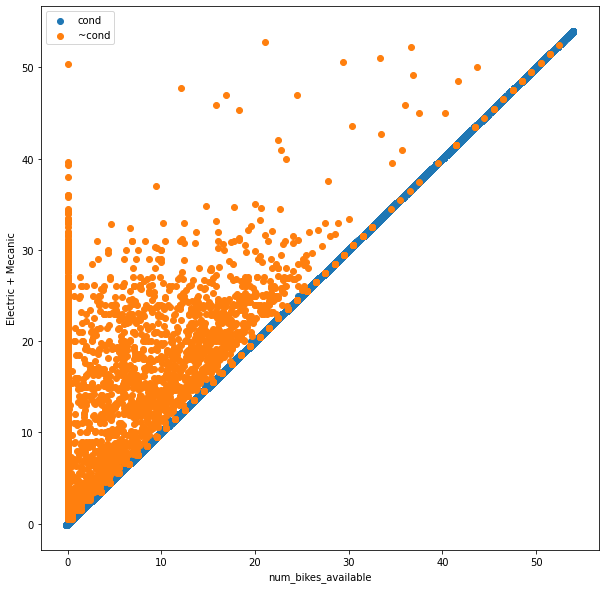

In [23]:
%%time

cond = data[config_year.year].num_bikes_available.round().astype(int) == (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']).round().astype(int)

print('correct data',data[config_year.year][cond].shape[0].compute(), 'incorrect data', data[config_year.year][~cond].shape[0].compute())
    
plt.rcParams["figure.figsize"] = (10,10)
    
plt.scatter(
    data[config_year.year][cond].num_bikes_available.compute(), 
    (data[config_year.year][cond]['num_bikes_available_types.ebike'] + data[config_year.year][cond]['num_bikes_available_types.mechanical']).compute(),
    label='cond'
)

plt.scatter(
    data[config_year.year][~cond].num_bikes_available.compute(), 
    (data[config_year.year][~cond]['num_bikes_available_types.ebike'] + data[config_year.year][~cond]['num_bikes_available_types.mechanical']).compute(),
    label='~cond'
)

plt.ylabel('Electric + Mecanic')
plt.xlabel('num_bikes_available')
plt.legend()

In [24]:
%%time

data[config_year.year]['num_bikes_available'] = data[config_year.year]['num_bikes_available'].mask(~cond, (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']))


CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 9.82 ms


correct data 3581856 incorrect data 0
CPU times: user 1.84 s, sys: 0 ns, total: 1.84 s
Wall time: 5.81 s


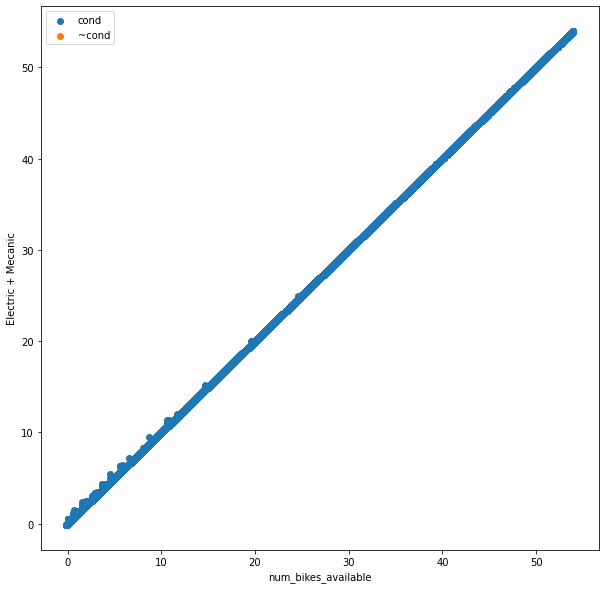

In [25]:
%%time

cond = data[config_year.year].num_bikes_available.round().astype(int) == (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']).round().astype(int)

print('correct data',data[config_year.year][cond].shape[0].compute(), 'incorrect data', data[config_year.year][~cond].shape[0].compute())

plt.rcParams["figure.figsize"] = (10,10)
    
plt.scatter(
    data[config_year.year][cond].num_bikes_available.compute(), 
    (data[config_year.year][cond]['num_bikes_available_types.ebike'] + data[config_year.year][cond]['num_bikes_available_types.mechanical']).compute(),
    label='cond'
)

plt.scatter(
    data[config_year.year][~cond].num_bikes_available.compute(), 
    (data[config_year.year][~cond]['num_bikes_available_types.ebike'] + data[config_year.year][~cond]['num_bikes_available_types.mechanical']).compute(),
    label='~cond'
)

plt.ylabel('Electric + Mecanic')
plt.xlabel('num_bikes_available')
plt.legend()

In [26]:
# Now capacity of a station must be something similar to the sum of available bikes and available docks

In [27]:
%%time

data[config_year.year]['capacity'] = data[config_year.year].num_bikes_available + data[config_year.year].num_docks_available

stations_max_capacity = data[config_year.year].groupby(['station_id'])['capacity'].max().reset_index()

# drop capacity 
data[config_year.year] = data[config_year.year].drop(['capacity'], axis=1)

# merge with stations_max_capacity
data[config_year.year] = data[config_year.year].merge(stations_max_capacity.copy(), how='left', on=['station_id'])


CPU times: user 31.5 ms, sys: 0 ns, total: 31.5 ms
Wall time: 30.4 ms


In [28]:
%%time

print(stats.describe(data[config_year.year]['capacity']))
data[config_year.year]['capacity'].describe().compute()

DescribeResult(nobs=3581856, minmax=(0.0, 54.000000000000014), mean=26.893874020264157, variance=34.516234396592594, skewness=0.8775981803887362, kurtosis=5.10355749754719)
CPU times: user 749 ms, sys: 0 ns, total: 749 ms
Wall time: 2.63 s


count    3.581856e+06
mean     2.689387e+01
std      5.875052e+00
min      0.000000e+00
25%      2.400000e+01
50%      2.700000e+01
75%      2.800000e+01
max      5.400000e+01
Name: capacity, dtype: float64

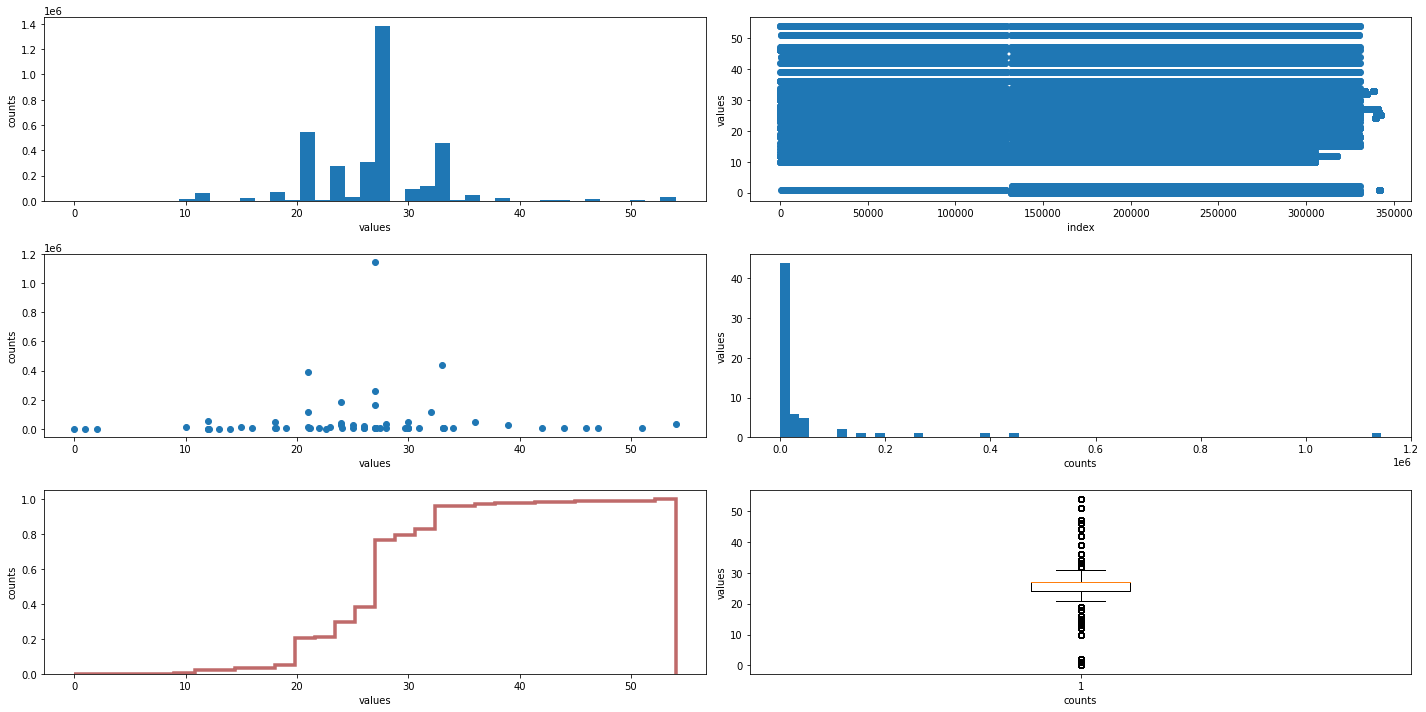

CPU times: user 8.7 s, sys: 326 ms, total: 9.03 s
Wall time: 8.54 s


In [29]:
%%time

show_counts(data[config_year.year]['capacity'].compute())

## find the percentage of docks available

In [30]:
%%time

data[config_year.year]['ctx0'] = data[config_year.year].num_docks_available / data[config_year.year].capacity


CPU times: user 15.7 ms, sys: 0 ns, total: 15.7 ms
Wall time: 14.1 ms


In [31]:
%%time

print(stats.describe(data[config_year.year]['ctx0']))
data[config_year.year]['ctx0'].describe().compute()

DescribeResult(nobs=3581856, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
CPU times: user 859 ms, sys: 58.3 ms, total: 917 ms
Wall time: 2.75 s


count    3.580548e+06
mean     5.817614e-01
std      3.297836e-01
min      0.000000e+00
25%      4.642857e-01
50%      7.893519e-01
75%      1.000000e+00
max      1.000000e+00
Name: ctx0, dtype: float64

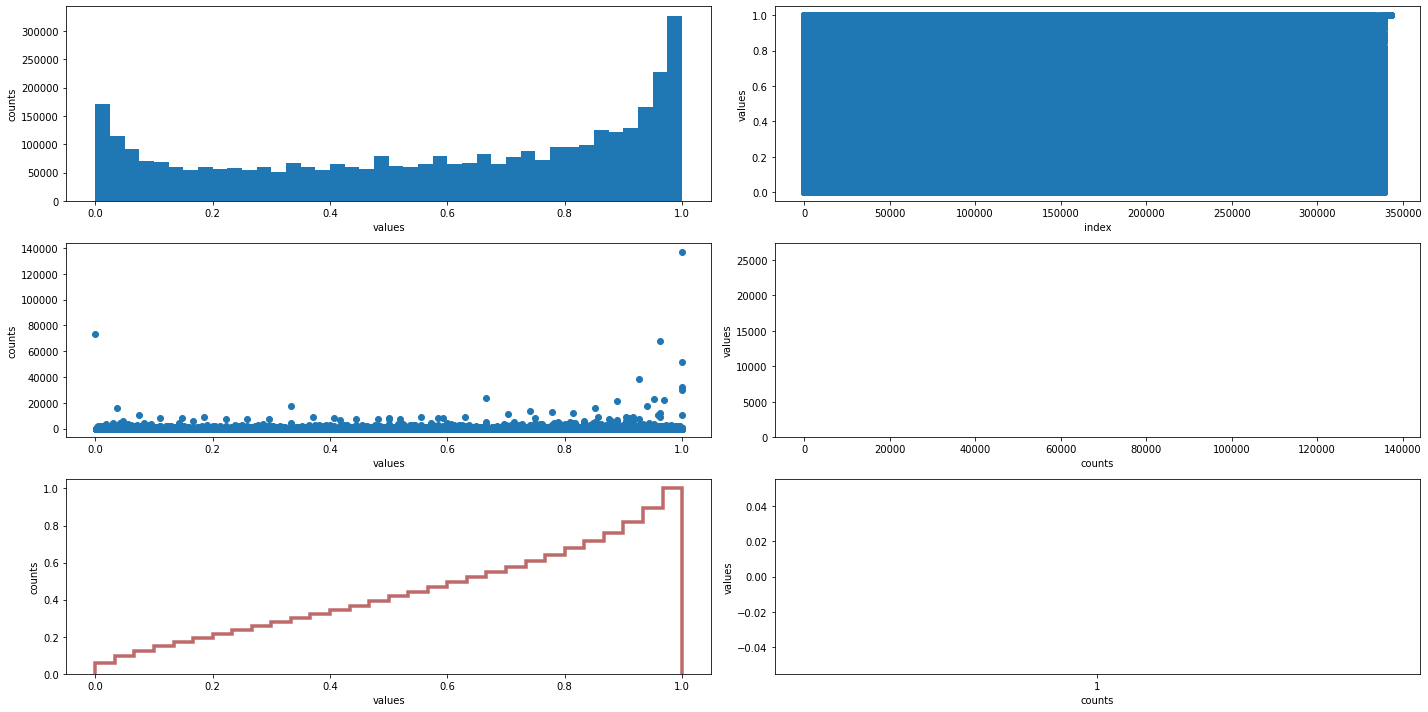

CPU times: user 1min 48s, sys: 14.7 s, total: 2min 3s
Wall time: 2min


In [32]:
%%time

show_counts(data[config_year.year]['ctx0'].compute())

### Generating new columns of past 4 hours

In [33]:
%%time

ctx = data[config_year.year][['station_id', 'timestamp', 'ctx0']].copy()
# ctx = ctx.rename(columns={'num_docks_available': 'ctx0'})
print(ctx.columns)

for i in range(1,5): 
    ctx = ctx.rename(columns={f'ctx{i-1}': f'ctx{i}'})
    print(ctx.columns)
    
    ctx.timestamp = ctx.timestamp + 3600 
    data[config_year.year] = data[config_year.year].merge(ctx.copy(), how='left', on=['station_id','timestamp'])
    
    cond = data[config_year.year][f'ctx{i}'].isna()
    data[config_year.year][f'ctx{i}'] = data[config_year.year][f'ctx{i}'].mask(cond, data[config_year.year][f'ctx{i-1}'])


Index(['station_id', 'timestamp', 'ctx0'], dtype='object')
Index(['station_id', 'timestamp', 'ctx1'], dtype='object')
Index(['station_id', 'timestamp', 'ctx2'], dtype='object')
Index(['station_id', 'timestamp', 'ctx3'], dtype='object')
Index(['station_id', 'timestamp', 'ctx4'], dtype='object')
CPU times: user 209 ms, sys: 6.57 ms, total: 216 ms
Wall time: 210 ms


In [34]:
data[config_year.year].columns

Index(['station_id', 'num_docks_available', 'num_bikes_available', 'status',
       'timestamp', 'is_installed', 'is_renting', 'is_returning',
       'is_charging_station', 'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3',
       'ctx4'],
      dtype='object')

In [35]:
%%time

get_features_nans(data[config_year.year])

CPU times: user 10.1 s, sys: 325 ms, total: 10.5 s
Wall time: 21 s


{'ctx0': 0.03634491322651968,
 'ctx1': 0.03634491322651968,
 'ctx2': 0.03634491322651968,
 'ctx3': 0.03634491322651968,
 'ctx4': 0.03634491322651968}

In [36]:
%%time

save_checkpoint(data[config_year.year], config_year)

# checkpoint saved.

checkpoint saved.
CPU times: user 3.26 s, sys: 232 ms, total: 3.49 s
Wall time: 28 s
